### Contributions
Kent Karsten Pangestu
* Task 1,2,3,4

In [11]:
import gym
import base64
import glob
import io
from IPython import display as ipythondisplay
from IPython.display import HTML
from gym.wrappers import RecordVideo
import base64
from gym import logger as gymlogger
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# CartPole Environment

In [12]:
env = gym.make("CartPole-v1")

print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")

Action Space: Discrete(2)
Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


### Action Space
The action space takes discrete values of either **0** or **1**, pushing the cart to the left or right respectively.

### Observation Space
The observation space takes continuous values, summarised in the table below.

<table style="width:70%; font-size: 14px; border: 1px solid black; border-collapse: collapse;">
  <tr>
    <th>Num</th>
    <th>Observation</th>
    <th>Min</th>
    <th>Max</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Cart Position</td>
    <td>-4.8</td>
    <td>4.8</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Cart Velocity</td>
    <td>-Inf</td>
    <td>Inf</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Pole Angle</td>
    <td>~ -0.418 rad (-24°)</td>
    <td>~ 0.418 rad (24°)</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Pole Angular Velocity</td>
    <td>-Inf</td>
    <td>Inf</td>
  </tr>
</table>

### Reward
Since the goal is to keep the pole upright for as long as possible, a reward of **+1** for every step taken, including the termination step, is allotted.


### Starting State
All observations are assigned a uniformly random value in (-0.05, 0.05).

### Terminating Conditions
An episode ends if any one of the following occurs:

* Pole Angle is greater than ±12°

* Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)

* Episode length is greater than 500


### Task 1:  Development of an RL Agent

We implemented the Monte-Carlo: Control algorithm as outlined below.

![alt text](mc_algorithm.png)

Since all 4 observed values in the observation space are continuous, we need to discretise them into bins. 

* `cart_position` is split into **4** bins with intervals of **2.5**
* `cart_velocity` is split into **4** bins with intervals of **2.5** 
* `pole_angle` is split into **10** bins with intervals of **0.1** 
* `pole_angular_velocity` is split into **40** bins with intervals of **0.25**

Through trial-and error, we found that `pole_angular_velocity` is the most important factor in the learning growth, followed by `pole_angle`. Hence, they are set with relatively more bins to account for more precise changes.

In [13]:
cart_position_bins = np.linspace(-4.8, 4.8, 4)
cart_velocity_bins = np.linspace(-5, 5, 4)
pole_angle_bins = np.linspace(-0.5, 0.5, 10)
pole_angular_velocity_bins = np.linspace(-5, 5, 40)

We determined that exploration is much more important than exploitation in this context due to the large state space. Hence, the hyperparameters are adjusted to accommodate exploration over exploitation in the beginning stages. More specifically,

* `discount_factor γ` determines the importance of future rewards when evaluating the expected returns from a state-action pair. It is set at **0.99** to prioritise long-term rewards, encouraging the agent to learn strategies that optimise the overall return rather than focusing only on immediate rewards.

* `epsilon ϵ` adds noise to allow the agent to explore other actions besides the current best-known action at a given state. It is set at **1** to encourage complete exploration early on when it has little knowledge of the environment, which is especially important in large state spaces.

* `epsilon_decay` decreases ϵ over time. It is set at **0.9995** to gradually transition to exploitation over exploration as the agent gains more knowledge and becomes more confident in its decisions.

* `epsilon_min` sets a minimum threshold allowed for ϵ. It is set at **0.07** to ensure that the agent keeps exploring even at the later stages, preventing overly greedy actions that only satisfies a local optima.


In [14]:
class Monte_Carlo():
    def __init__(self, env, discount_factor = 0.99, epsilon = 1.0, epsilon_decay = 0.9995, epsilon_min = 0.07) -> None:
        self.env = env
        self.q_table = defaultdict(int)
        self.returns = defaultdict(int)
        self.visits = defaultdict(int)
        self.discount_factor = discount_factor # γ
        self.epsilon = epsilon # ϵ
        self.epsilon_decay = epsilon_decay 
        self.epsilon_min = epsilon_min 
    
    def discretise_state(self, state: np.ndarray) -> tuple:
        """Puts the state values into the respective discrete bins."""
        cart_position, cart_velocity, pole_angle, pole_angular_velocity = state
        
        cart_position = np.digitize(cart_position, cart_position_bins) - 1
        cart_velocity = np.digitize(cart_velocity, cart_velocity_bins) - 1
        pole_angle = np.digitize(pole_angle, pole_angle_bins) - 1
        pole_angular_velocity = np.digitize(pole_angular_velocity, pole_angular_velocity_bins) - 1
        return (cart_position, cart_velocity, pole_angle, pole_angular_velocity)
    
    def decay_epsilon(self) -> None:
        """Decays epsilon after each episode."""
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

    def policy(self, state) -> int:
        """Rule to determine which action to take at a particular state."""
        if np.random.rand() < self.epsilon: # Noise added
            return self.env.action_space.sample()
        else:
            return max(range(self.env.action_space.n), key=lambda a: self.q_table.get((state, a), np.random.uniform(low=0, high=1)))

    def generate_episode(self) -> tuple:
        """Generates one round of play."""
        episode = []
        state, _ = self.env.reset() # Environment is reset at the beginning of each episode
        state = self.discretise_state(state)
        done = False
        cumulative_reward = 0
        while not done:
            action = self.policy(state)
            next_state, reward, done, _, _ = self.env.step(action)
            episode.append((state, action, reward))
            state = self.discretise_state(next_state)
            cumulative_reward += reward
            if cumulative_reward > 499:
                break
        return (episode, cumulative_reward)
    
    def update_q_table(self, episode) -> None:
        """Computes returns using first-visit MC method."""
        G = 0
        state_action_visited = defaultdict(int)

        # Iterate backwards according to G(t) = r(t) + y * G(t+1)
        for i in reversed(range(len(episode))):
            state, action, reward = episode[i]
            G = reward + self.discount_factor * G
            state_action_visited[(state, action)] = G

            for key, val in state_action_visited.items():
                # Update Q table for each state-action pair
                self.returns[key] += val
                self.visits[key] += 1
                self.q_table[key] = self.returns[key] / self.visits[key]
    
    def train_episodes(self, num_episodes) -> None:
        reward = 0 
        for i in range(1,num_episodes+2):
            episode , cumulative_reward = self.generate_episode()
            self.update_q_table(episode)
            reward += cumulative_reward
            self.decay_epsilon()   
            if i % 1000 == 0:
                print(f"Mean reward for the first {i} episodes: {reward/1000}")
                reward = 0
        
    def run(self, raw_state) -> int:
        """Determines the optimal action to take based on current knowledge."""
        state = self.discretise_state(raw_state)
        return max(range(self.env.action_space.n), key=lambda a: self.q_table.get(state, a))
    
    def test_episodes(self, num_episodes) -> list:
        reward_list = []

        for episode in range(num_episodes):
            state, _ = self.env.reset()
            done = False
            cumulative_reward = 0

            while not done:
                action = self.run(state)
                next_state, reward, done, _, _ = self.env.step(action)
                cumulative_reward += reward
                if cumulative_reward > 499:
                    break
                state = next_state
                
            reward_list.append(cumulative_reward)
            
        return reward_list

The agent is trained on 6000 episodes, and the average reward every 1000 episodes is indicated to highlight the agent's progress.

In [15]:
Monte_Carlo_Agent = Monte_Carlo(env)
Monte_Carlo_Agent.train_episodes(6000)

Mean reward for the first 1000 episodes: 46.131
Mean reward for the first 2000 episodes: 142.257
Mean reward for the first 3000 episodes: 199.851
Mean reward for the first 4000 episodes: 195.692
Mean reward for the first 5000 episodes: 190.172
Mean reward for the first 6000 episodes: 189.354


We also implemented the Q-Learning algorithm as outlined below. We found that Q-Learning is a much more effective algorithm, given the same hyperparameters. 

<img src="q_learning_algorithm.png" width="800" height="340">

We explored the algorithm given the same number of bins for each variable, the same values for `discount_factor γ` at 0.99, `epsilon ϵ` at 1, `epsilon_decay` at 0.995, and `epsilon_min` at 0.07 as with the previous algorithm. In addition, we added `learning_rate α`, which is needed in a Q-Learning algorithm.

* `learning_rate α` controls how much the Q-values are updated in each step of an episode. It is set low at **0.1** to allow for more stability during the training process by ensuring that the agent learns more gradually.


In [21]:
class QLearning:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.99,
                 epsilon=1.0, epsilon_decay=0.9995, epsilon_min=0.07):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.observation = [4, 4, 10, 40] # Number of bins set for each variable in an observation
        self.window_size = np.array([2.5, 2.5, 0.1, 0.25]) # Size of each bin
        self.q_table = np.random.uniform(low=0, high=1, size=(self.observation + [env.action_space.n])) # Q-table initialised with arbitrary values

    def discretise_state(self, state):
        discrete_state = state/self.window_size + np.array([2,2,5,20]) # Normalise the state values to ensure they are within bounds of the bin 
        return tuple(discrete_state.astype(int)) # Truncate and convert to tuple to use as a key in the Q-table

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def policy(self, state):
        if np.random.random() < self.epsilon: # Noise added
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_table[state]) 
        
    def generate_episode(self):
        state, _ = self.env.reset()
        state = self.discretise_state(state)
        done = False
        cumulative_reward = 0

        while not done:
            action = self.policy(state)
            next_state, reward, done, _, _ = self.env.step(action)
            next_state = self.discretise_state(next_state)
            cumulative_reward += reward

            if cumulative_reward > 499:
                break
            
            self.update_q_table(state, next_state, action, reward)
            state = next_state


        return cumulative_reward

    def update_q_table(self, state, next_state, action, reward):
        current_q = self.q_table[state + (action,)]
        next_max_q = np.max(self.q_table[next_state])
        
        # Update Q-value using the Bellman equation: Q(s, a) = (1 - α) * Q(s, a) + α * (r + γ * max_a(Q(s', a')))
        new_q = (1 - self.learning_rate) * current_q + self.learning_rate * (reward + self.discount_factor * next_max_q)
        self.q_table[state + (action,)] = new_q

    def train_episodes(self, num_episodes):
        reward = 0 
        for episode in range(1,num_episodes+2):
            reward += self.generate_episode()
            self.decay_epsilon()   
            if episode % 1000 == 0:
                print(f"Mean reward for the first {episode} episodes: {reward/1000}")
                reward = 0
        
        return reward
    
    def run(self, raw_state):
        """Determines the optimal action to take based on current knowledge."""
        state = self.discretise_state(raw_state)
        action = np.argmax(self.q_table[state])
        return action
    
    def test_episodes(self, num_episodes):
        reward_list = []

        for episode in range(num_episodes):
            state, _ = self.env.reset()
            done = False
            cumulative_reward = 0

            while not done:
                action = self.run(state)
                next_state, reward, done, _, _ = self.env.step(action)
                cumulative_reward += reward
                if cumulative_reward > 499:
                    break
                state = next_state
                
            reward_list.append(cumulative_reward)
            
        return reward_list


The agent is trained on 5000 episodes, and the average reward every 1000 episodes is indicated to highlight the agent's progress.

In [22]:
Q_agent = QLearning(env)
Q_agent.train_episodes(5000)

Mean reward for the first 1000 episodes: 32.321
Mean reward for the first 2000 episodes: 148.846
Mean reward for the first 3000 episodes: 314.279
Mean reward for the first 4000 episodes: 401.773
Mean reward for the first 5000 episodes: 414.346


500.0

We can see that the agent learns much better with Q-Learning than Monte-Carlo. 

### Hence, we will be using the Q-Learning agent for the remaining tasks.

The agent is tested on a random state of the environment.

In [23]:
state, _ = env.reset()
action = Q_agent.run(state)
print("Observation:", state)
print("Chosen action:", action)

Observation: [-4.6075437e-02 -4.1246563e-02  6.3011728e-05  3.4020457e-02]
Chosen action: 1


### Task 2: Demonstrate the effectiveness of the RL agent

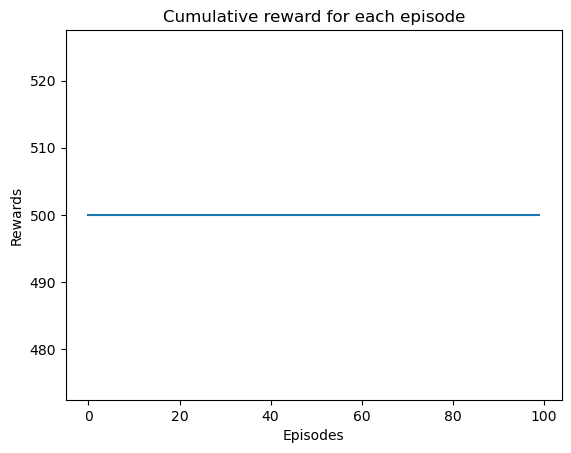

Average cumulative reward: 500.0
Is my agent good enough? True


In [24]:
episode_results = Q_agent.test_episodes(100)

plt.plot(episode_results)
plt.title("Cumulative reward for each episode")
plt.ylabel('Rewards')
plt.xlabel('Episodes')
plt.show()

print("Average cumulative reward:", np.mean(episode_results))
print("Is my agent good enough?", np.mean(episode_results) > 195)

### Task 3: Render one episode played by the agent

In [26]:
def show_video():
    """Finds and displays the recorded video."""
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'rb').read()
        encoded = base64.b64encode(video).decode('ascii')
        display(HTML(f'<video width="600" controls><source src="data:video/mp4;base64,{encoded}" type="video/mp4"></video>'))
    else:
        print("Could not find video")

def videoEpisode(agent):
    """Runs one episode, recording the video."""
    env = RecordVideo(gym.make('CartPole-v1', render_mode='rgb_array'), "./video")
    state, _ = env.reset()
    
    done = False
    while not done:
        action = agent.run(state)  # Assuming `agent.run(state)` chooses an action
        next_state, reward, done, _, _ = env.step(action)
        state = next_state
    
    env.close()
    show_video()

    return

# Call videoEpisode and pass your agent
videoEpisode(Q_agent)

MoviePy - Building video d:\Files\VS Code\SC3000\SC3000\video\rl-video-episode-0.mp4.
MoviePy - Writing video d:\Files\VS Code\SC3000\SC3000\video\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready d:\Files\VS Code\SC3000\SC3000\video\rl-video-episode-0.mp4
